In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import numpy as np
from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('responsi_data.csv', delimiter=';')
df.head()

,id,kode_produk,review,aspect_term_sentiment
0,665c7e0a528efa52655054b3,101646,akhirnya lengkap mulai lengkap variant ini.. j...,"""[{'term': 'tekstur', 'polarity': 'positive'}]"""
1,6619efc643e0623f85cb6ae7,98204,kalo untuk sunscreen spray i only trust skinti...,"""[{'term': 'lainnya', 'polarity': 'positive'}]"""
2,66644ab34658891e039ee5f2,101646,sunscreen terbagus a!! ngl ini benaran se ligh...,"""[{'term': 'tekstur', 'polarity': 'positive'},..."
3,676ee9bc3a193c2c6ef45f3a,101646,produk krim perawatan wajah ini memberikan pen...,"""[{'term': 'tekstur', 'polarity': 'positive'}]"""
4,67528577576d796c08b4080e,98204,"cepat habis padahal sudah beli yang gede, tapi...","""[{'term': 'aroma', 'polarity': 'neutral'}]"""


In [3]:
def get_first_polarity(sentiment_str):
    try:
        if sentiment_str.startswith('"""') and sentiment_str.endswith('"""'):
            sentiment_str = sentiment_str[3:-3]
        elif sentiment_str.startswith('"') and sentiment_str.endswith('"'):
            sentiment_str = sentiment_str[1:-1]

        sentiment_list = ast.literal_eval(sentiment_str)

        if sentiment_list and len(sentiment_list) > 0:
            return sentiment_list[0]['polarity']
        return None
    except (ValueError, SyntaxError, KeyError, IndexError):
        return None

df['sentiment'] = df['aspect_term_sentiment'].apply(get_first_polarity)
df.head()


,id,kode_produk,review,aspect_term_sentiment,sentiment
0,665c7e0a528efa52655054b3,101646,akhirnya lengkap mulai lengkap variant ini.. j...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive
1,6619efc643e0623f85cb6ae7,98204,kalo untuk sunscreen spray i only trust skinti...,"""[{'term': 'lainnya', 'polarity': 'positive'}]""",positive
2,66644ab34658891e039ee5f2,101646,sunscreen terbagus a!! ngl ini benaran se ligh...,"""[{'term': 'tekstur', 'polarity': 'positive'},...",positive
3,676ee9bc3a193c2c6ef45f3a,101646,produk krim perawatan wajah ini memberikan pen...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive
4,67528577576d796c08b4080e,98204,"cepat habis padahal sudah beli yang gede, tapi...","""[{'term': 'aroma', 'polarity': 'neutral'}]""",neutral


## Preprocessing

#### Visualisasi

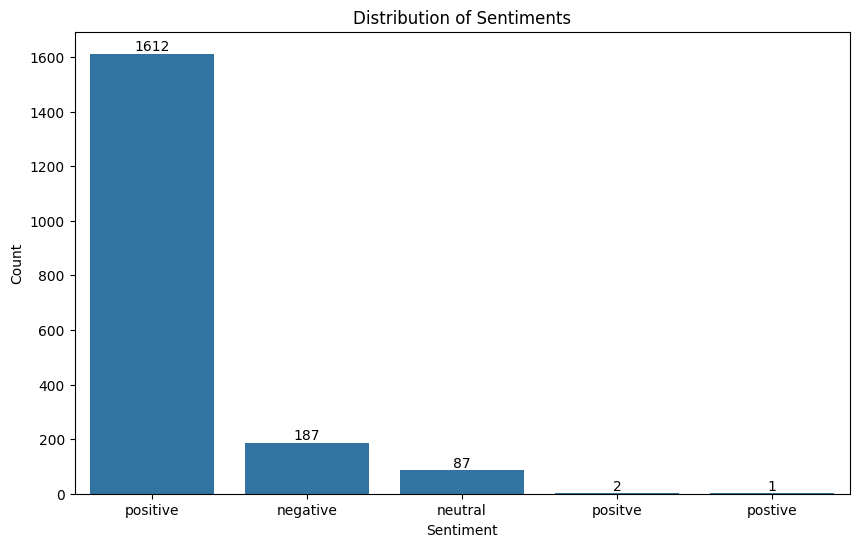

In [4]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


#### Preprocessing

In [5]:
df['sentiment'] = df['sentiment'].replace(['positve', 'postive'], 'positive')

In [6]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stopwords = StopWordRemoverFactory().get_stop_words()

In [7]:
import re
import pandas as pd
from tqdm import tqdm

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[0-9]+|[^\w\s]', '', text)

    words = text.split()
    words = [word for word in words if word not in stopwords]

    text = ' '.join(words)

    return text

batch_size = 1000
processed_reviews = []

for i in tqdm(range(0, len(df), batch_size)):
    batch = df['review'].iloc[i:i+batch_size]
    processed = [preprocess_text(text) for text in batch]
    processed_reviews.extend(processed)

df['processed_review'] = processed_reviews

df.head()

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


,id,kode_produk,review,aspect_term_sentiment,sentiment,processed_review
0,665c7e0a528efa52655054b3,101646,akhirnya lengkap mulai lengkap variant ini.. j...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive,akhirnya lengkap mulai lengkap variant jujurly...
1,6619efc643e0623f85cb6ae7,98204,kalo untuk sunscreen spray i only trust skinti...,"""[{'term': 'lainnya', 'polarity': 'positive'}]""",positive,kalo sunscreen spray i only trust skintific in...
2,66644ab34658891e039ee5f2,101646,sunscreen terbagus a!! ngl ini benaran se ligh...,"""[{'term': 'tekstur', 'polarity': 'positive'},...",positive,sunscreen terbagus a ngl benaran se lightweigh...
3,676ee9bc3a193c2c6ef45f3a,101646,produk krim perawatan wajah ini memberikan pen...,"""[{'term': 'tekstur', 'polarity': 'positive'}]""",positive,produk krim perawatan wajah memberikan pengala...
4,67528577576d796c08b4080e,98204,"cepat habis padahal sudah beli yang gede, tapi...","""[{'term': 'aroma', 'polarity': 'neutral'}]""",neutral,cepat habis padahal beli gede aku pakainya tia...


In [8]:
indo_slang_word = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")

slang_dict = dict(zip(indo_slang_word['slang'], indo_slang_word['formal']))

def replace_slang_words(text):
    words = text.split()
    replaced_words = []

    for word in words:
        if word in slang_dict:
            replaced_words.append(slang_dict[word])
        else:
            replaced_words.append(word)

    return ' '.join(replaced_words)

df['processed_review'] = df['processed_review'].apply(replace_slang_words)

#### Visualisasi Worldcloud

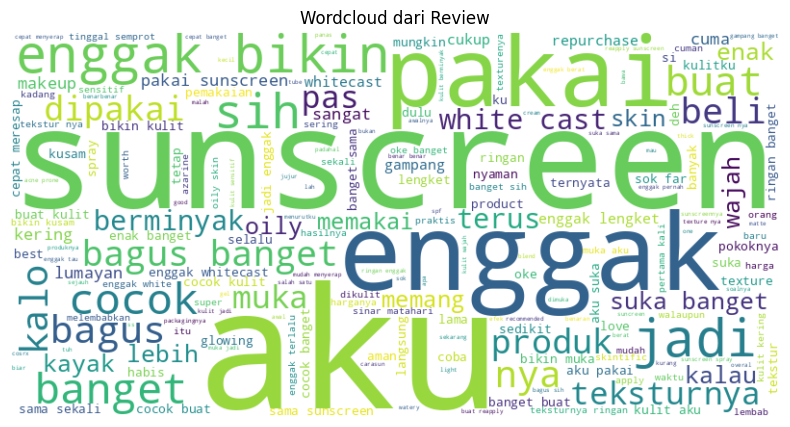

In [9]:
text = ' '.join(df['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud dari Review')
plt.show()


## Term Weighting

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # You can adjust max_features

# Fit and transform the processed reviews
X = tfidf_vectorizer.fit_transform(df['processed_review']).toarray()

print(X[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Classification

In [13]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
label_map = {2: 'positive', 1: 'neutral', 0: 'negative'}

df_clean = df.dropna(subset=['sentiment']).copy()

# Align X with df_clean by selecting the rows that exist in df_clean
X_clean = X[df_clean.index]
y = df_clean['sentiment'].map(sentiment_map).values

print("Original class distribution:", Counter(y))

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_clean, y) # Use the aligned TF-IDF features X_clean

print("Class distribution after SMOTE:", Counter(y_smote))

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote,
                                                                            y_smote,
                                                                            test_size=0.2,
                                                                            random_state=42)

svm_model_smote = SVC(kernel='rbf', random_state=42)
svm_model_smote.fit(X_train_smote, y_train_smote)

predictions_smote = svm_model_smote.predict(X_test_smote)

predictions_text_smote = [label_map[pred] for pred in predictions_smote]
actual_labels_text_smote = [label_map[label] for label in y_test_smote]

print("\nClassification Report after SMOTE:")
print(classification_report(actual_labels_text_smote, predictions_text_smote))

Original class distribution: Counter({2: 1615, 0: 187, 1: 87})
Class distribution after SMOTE: Counter({2: 1615, 1: 1615, 0: 1615})

Classification Report after SMOTE:
              precision    recall  f1-score   support

    negative       1.00      0.98      0.99       304
     neutral       1.00      1.00      1.00       325
    positive       0.98      1.00      0.99       340

    accuracy                           0.99       969
   macro avg       0.99      0.99      0.99       969
weighted avg       0.99      0.99      0.99       969



In [14]:
from sklearn.metrics import classification_report

print(classification_report(actual_labels_text_smote, predictions_text_smote))

              precision    recall  f1-score   support

    negative       1.00      0.98      0.99       304
     neutral       1.00      1.00      1.00       325
    positive       0.98      1.00      0.99       340

    accuracy                           0.99       969
   macro avg       0.99      0.99      0.99       969
weighted avg       0.99      0.99      0.99       969



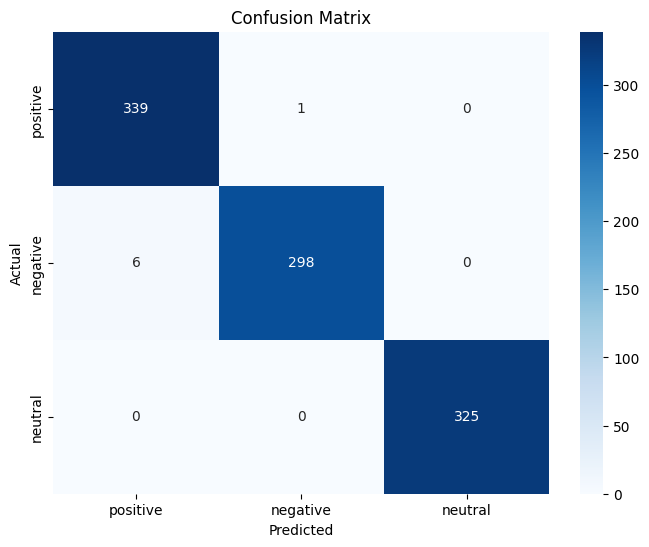

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_smote = confusion_matrix(actual_labels_text_smote, predictions_text_smote, labels=['positive', 'negative', 'neutral'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the indices of the test set from the original data before SMOTE
# This requires splitting the original clean data first to get the indices
# then using those indices to select the corresponding rows from X_clean and y.

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,
                                                                            y,
                                                                            test_size=0.2,
                                                                            random_state=42,
                                                                            stratify=y) # Stratify to maintain class distribution

# Train the SVM model on the original (non-SMOTE) training data for misclassification analysis
svm_model_orig = SVC(kernel='rbf', random_state=42)
svm_model_orig.fit(X_train_clean, y_train_clean)

# Predict on the original (non-SMOTE) test data
predictions_orig = svm_model_orig.predict(X_test_clean)

# Get the indices of the misclassified samples in the original test set
misclassified_indices_orig = [i for i, (actual, pred) in enumerate(zip(y_test_clean, predictions_orig)) if actual != pred]

# Get the original DataFrame indices for the misclassified samples in the test set
# Need to get the actual indices from the original df_clean that were part of the test split
# We can get this from the index of X_test_clean if X_clean retained the original index.
# Since X_clean is a slice of X, and X was created from df['processed_review'], the indices should be preserved.
original_test_indices = df_clean.iloc[X_train_clean.shape[0]:].index # Assuming train_test_split doesn't reindex

# If the above assumption is incorrect, we need a more robust way to track indices.
# Let's use a simpler approach by splitting the df_clean directly and using its index
df_train, df_test = train_test_split(df_clean,
                                    test_size=0.2,
                                    random_state=42,
                                    stratify=df_clean['sentiment'])

# Now use the index of the test set from the original df_clean split
original_test_indices = df_test.index

# Get the original DataFrame indices for the misclassified samples
# These indices are relative to the X_test_clean array, so we need to map them back
# to the original df_clean indices using the original_test_indices
misclassified_df_indices = original_test_indices[misclassified_indices_orig]

misclassified_reviews = df_clean.loc[misclassified_df_indices]['review']
misclassified_actual = [label_map[y_test_clean[i]] for i in misclassified_indices_orig]
misclassified_predicted = [label_map[predictions_orig[i]] for i in misclassified_indices_orig]


misclassified_df = pd.DataFrame({
    'review': misclassified_reviews,
    'actual_sentiment': misclassified_actual,
    'predicted_sentiment': misclassified_predicted
})

print("\nMisclassified Samples (Analysis on Original Data Split):")
display(misclassified_df.head())

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'